In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

seed = 42
np.random.seed(seed=seed)

def train_generator(X_train, y_train, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_train), batch_size):
            x_batch = []
            y_batch = []            
            end = min(start + batch_size, len(X_train))
            train_batch = X_train[start:end]
            labels_batch = y_train[start:end]
            for i in range(len(train_batch)):
                data, _ = librosa.load(train_batch[i], sr = SR)
#                 data = random_data_shift(data, u = .2)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch

def valid_generator(X_val, y_val, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_val), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(X_val))
            test_batch = X_val[start:end]
            labels_batch = y_val[start:end]
            for i in range(len(test_batch)):
                data, _ = librosa.load(test_batch[i], sr = SR)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch
            
splitting = 'custom'
data_setting = 'raw'
model_setting = 'conv1d'

### Splitting mosquito data same way it was split to train

In [2]:
d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

# Merging the mosquito genuses together
y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

Species: all.
Read 279566 filenames in 1.02 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.45 seconds.
['20170209', '20161213', '20161212', '20170212', '20170208', '20170207', '20170206', '20170210', '20170211', '20170213']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.45 seconds.
['20170228', '20170103', '20170301', '20170227', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.46 seconds.
['20170203', '20170204', '20170318', '20170202', '20170130', '20170319', '20170201', '20170315', '20170316', '20170314', '20170205', '20170317', '20170131', '20170206', '20170313', '20170320']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.43 seconds.
['20170109', '20170110', '20170120', '20170121', '20170122', '20170117', '20170123', '20170116', '20170119', '20170118']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Rea

### Loading MosquitoNet and removing its last 2 layers

In [3]:
# Defining model parameters
merged = False
if merged:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
using_conv2d = False
traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# NOT LOADING MODELS
model.load_weights(TEMP_DATADIR+modelname+'.h5')
model.summary()

# cut_mosquito_model is the model without its last dropout and softmax
cut_mosquito_model = Model(model.inputs, model.layers[-3].output)

############ INPUT SHAPE:(5000, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4998, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 16)          784       
_________________________________________________________________
batch_normalization (BatchNo (None, 4996, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4994, 32)          1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4992, 32)          3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4992, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPoo

## Reading Flies data and splitting into Train/Val/Test

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sb
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import deepdish as dd

Species: all.
Read 10264 filenames in 0.03 seconds.
Species: D. melanogaster.
Read 8294 filenames in 0.05 seconds.
['20200131', '20200206', '20200203', '20200204', '20200205', '20200207', '20200202', '20200201', '20191231', '20200102', '20191230', '20200101', '20200307', '20200311', '20200309', '20200310', '20200308', '20200303', '20200312', '20200306', '20200304', '20200305', '20200314', '20200316', '20200313', '20200315', '20200113', '20200115', '20200112', '20200119', '20200116', '20200114', '20200118', '20200117', '20200106', '20200107', '20200105', '20200104', '20191225', '20191223', '20191228', '20191222', '20191221', '20191229', '20191220', '20191217', '20191224', '20191227', '20191226', '20191216', '20200103', '20200109', '20200110', '20200108', '20200111']
7623 train filenames, 671 test filenames
Species: D. suzukii.
Read 1970 filenames in 0.05 seconds.
['20200215', '20200217', '20200213', '20200219', '20200212', '20200216', '20200218', '20200208', '20200210', '20200209', '202

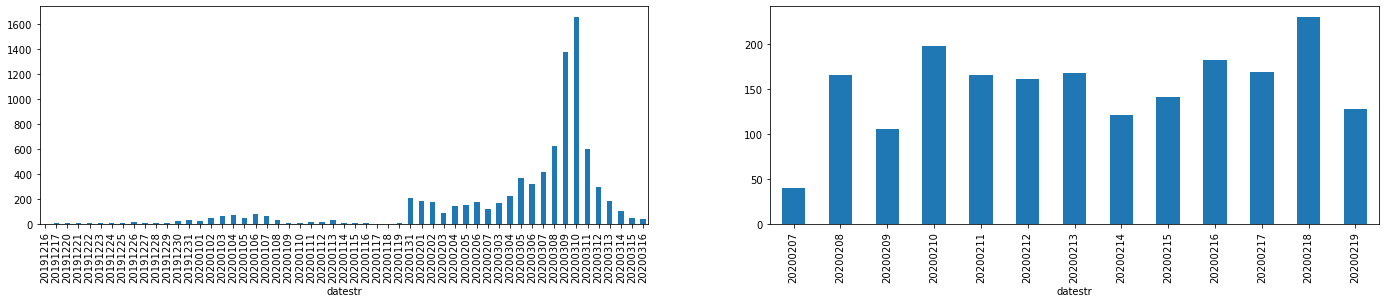

In [5]:
dconf = Dataset('Pcfruit_sensor49')
dconf.read(loadmat=False);
dconf.get_sensor_features(temp_humd=False)
sub = dconf.df_features

mel_test_dates = ['20191216','20191217','20191220','20191221','20191222','20191223',
                 '20191224','20191225','20191226','20191227','20191228','20191229',
                 '20191230','20191231','20200101','20200102','20200103','20200104',
                 '20200105','20200106','20200107','20200108','20200109','20200110',
                 '20200111','20200112','20200113','20200114','20200115','20200116',
                 '20200117','20200118','20200119']
suz_test_dates = ['20200219', '20200218']
plt.figure(figsize=(24,4))
plt.subplot(121)
mel_rest, mel_test = train_test_filenames(dconf, 'D. melanogaster', test_dates=mel_test_dates, plot=True)
plt.subplot(122)
suz_rest, suz_test = train_test_filenames(dconf, 'D. suzukii', test_dates=suz_test_dates, plot=True)

In [6]:
Xf_rest = pd.concat([mel_rest, suz_rest])
yf_rest = Xf_rest.apply(lambda x: x.split('/')[dconf.class_path_idx])
df_rest = pd.concat([Xf_rest, yf_rest], axis=1)
df_rest.columns = ['X','y']
lenc = LabelEncoder()
df_rest.y = lenc.fit_transform(df_rest.y).astype(float)
del Xf_rest, yf_rest

Xf_test = pd.concat([mel_test, suz_test]).tolist()
yf_test = pd.Series(Xf_test).apply(lambda x: x.split('/')[dconf.class_path_idx]).tolist()
yf_test = lenc.transform(yf_test).astype(float)

train, val = train_test_split(df_rest, shuffle=True, random_state=seed, test_size=0.08)
Xf_val, yf_val = val.X.tolist(), val.y.values

In [7]:
N = train.shape[0]
samples = [N]#[round(N/40), round(N/30), round(N/20), round(N/15), round(N/10), round(N/5), N] #, round(N/5), round(N/2), N]
print(samples)
freeze_layers = True
# frozen_layers = 18
train_shallow = True

def run_job(trial, freeze_layers=True):
    if not freeze_layers:
        froz_layerlist = [0]
    else:
        froz_layerlist = [5, 15, 19]
    
    for frozen_layers in froz_layerlist:
        results = []
        for smpl in samples:
            print(f'\n\n###########\nNOW USING {smpl} SAMPLES\n##############')
            smpl_results = {}

            train_smpl = shuffle(train.sample(smpl, random_state=seed), random_state=seed)
            Xf_train, yf_train = train_smpl.X.values, train_smpl.y.values 

            print(f"Train: \n{pd.Series(yf_train).value_counts()}")
            print(f"Val: \n{pd.Series(yf_val).value_counts()}")
            print(f"Test: \n{pd.Series(yf_test).value_counts()}")    

            class_weights = class_weight.compute_class_weight('balanced',
                                                             np.unique(yf_train),
                                                             yf_train)
            print(f'class_weights: {class_weights}')

            ### Creating a shallow model to put on top of Mosquito model
            cut_mosquito_model = Model(model.inputs, model.layers[-3].output)

            top_model = Sequential()
            top_model.add(Flatten(input_shape=cut_mosquito_model.output_shape[1:]))
            top_model.add(Dropout(0.5))
            top_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
            top_model.add(Dropout(0.5))
            top_model.add(Dense(1, activation='sigmoid'))
            top_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

            bs = 128
            if train_shallow:
                ### Passing fly data through the cut Mosquito model to get output
                ##### This output will be used to train the shallow model for few epochs

                X_flies_train = cut_mosquito_model.predict_generator(valid_generator(Xf_train, 
                                                                yf_train, 
                                                                batch_size=bs, 
                                                                setting='raw', 
                                                                target_names=['suz','mel']),
                                                            steps = int(math.ceil(float(len(Xf_train)) / float(bs))))

                X_flies_val = cut_mosquito_model.predict_generator(valid_generator(Xf_val, 
                                                                yf_val, 
                                                                batch_size=bs, 
                                                                setting='raw', 
                                                                target_names=['suz','mel']),
                                                            steps = int(math.ceil(float(len(Xf_val)) / float(bs))))

                ### Training Shallow model for a few epochs
                traincf_flies = TrainConfiguration(dataset=dconf, setting='raw', monitor='val_accuracy', model_name=f'top_model_flies', batch_size=32, epochs=10)
                top_model.fit(X_flies_train, yf_train, 
                              validation_data=(X_flies_val,yf_val),
                              batch_size=traincf_flies.batch_size, 
                              epochs=traincf_flies.epochs, 
                              callbacks=traincf_flies.callbacks_list,
                             class_weight=class_weights,
                             verbose=0);

            if freeze_layers:
                #### Freezing first few layers of MosquitoNet
                for lay in cut_mosquito_model.layers[:frozen_layers]:
                    lay.trainable = False

            ### Adding shallow model on top of the cut Mosquito model
            inputA = Input(cut_mosquito_model.input_shape[1:])
            outputA = cut_mosquito_model(inputA)
            outputB = top_model(outputA)
            modelC = Model(inputA, outputB)
            modelC.compile(loss='mse',
                          optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
                          metrics=['accuracy'])


            ### Training MosquitoNet+Shallow
            traincf_flies = TrainConfiguration(dataset=dconf, setting='raw', monitor='val_accuracy', es_patience=4, rlr_patience=4, model_name=f'whole_model_flies', batch_size=32)
            h = modelC.fit_generator(train_generator(Xf_train, yf_train, 
                                                batch_size=traincf_flies.batch_size,
                                                target_names=traincf_flies.target_names,
                                                setting=traincf_flies.setting),
                                steps_per_epoch = int(math.ceil(float(len(Xf_train)) / float(traincf_flies.batch_size))),
                                epochs = traincf_flies.epochs,
                                validation_data = valid_generator(Xf_val, yf_val,
                                                                    batch_size=traincf_flies.batch_size,
                                                                    target_names=traincf_flies.target_names,
                                                                    setting=traincf_flies.setting),
                                validation_steps=int(math.ceil(float(len(Xf_test))/float(traincf_flies.batch_size))),
                                callbacks=traincf_flies.callbacks_list, 
                                class_weight=class_weights, 
                                verbose=0);

            yf_pred = modelC.predict_generator(valid_generator(Xf_test, 
                                                            yf_test, 
                                                            batch_size=bs, 
                                                            setting='raw', 
                                                            target_names=['suz','mel']),
                                                        steps = int(math.ceil(float(len(Xf_test)) / float(bs))))

            lb = LabelBinarizer()
            thr = 0.5
            yf_pred_thresholded = lb.fit_transform(yf_pred > thr)
            cm = confusion_matrix(yf_test, yf_pred_thresholded).astype(float)
            smpl_results['yf_test'] = yf_test
            smpl_results['yf_pred'] = yf_pred
            smpl_results['yf_pred_thresholded'] = yf_pred_thresholded
            smpl_results['nr_samples'] = smpl
            smpl_results['freeze_layers'] = freeze_layers
            smpl_results['frozen_layers'] = frozen_layers
            smpl_results['train_shallow'] = train_shallow
            smpl_results['accuracy_score'] = accuracy_score(yf_test, yf_pred_thresholded)
            smpl_results['balanced_accuracy_score'] = balanced_accuracy_score(yf_test, yf_pred_thresholded)
            smpl_results['cm'] = cm
        #     smpl_results['classification_report'] = classification_report(yf_test, yf_pred_thresholded)
            smpl_results['history'] = h.history

            results.append(smpl_results)
            del cm, yf_train, h, yf_pred, yf_pred_thresholded, modelC, cut_mosquito_model, top_model, lb, smpl_results, traincf_flies


#         dd.io.save(f'../temp_data/merged{merged}_frozen{freeze_layers}_nr{frozen_layers}_TrShallow{train_shallow}_trial{trial}.csv', results)
        for res in results:
            print(res)
        del results

[8497]


In [9]:
# for i in range(10):
#     run_job(i, freeze_layers=True)
#     run_job(i, freeze_layers=False)
run_job(0, freeze_layers=True)



###########
NOW USING 8497 SAMPLES
##############
Train: 
0.0    7014
1.0    1483
dtype: int64
Val: 
0.0    609
1.0    130
dtype: int64
Test: 
0.0    671
1.0    357
dtype: int64
class_weights: [0.60571714 2.86480108]


KeyboardInterrupt: 